# LASSO example 
## tomography reconstruction with L1 prior (Lasso) from [here](http://scikit-learn.org/stable/auto_examples/applications/plot_tomography_l1_reconstruction.html#sphx-glr-auto-examples-applications-plot-tomography-l1-reconstruction-py)

Automatically created module for IPython interactive environment


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


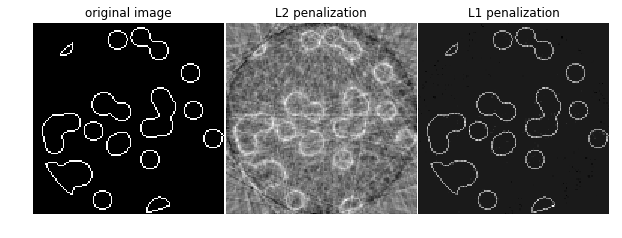

In [2]:
print(__doc__)

# Author: Emmanuelle Gouillart <emmanuelle.gouillart@nsup.org>
# License: BSD 3 clause

import numpy as np
from scipy import sparse
from scipy import ndimage
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
%matplotlib inline

def _weights(x, dx=1, orig=0):
    x = np.ravel(x)
    floor_x = np.floor((x - orig) / dx)
    alpha = (x - orig - floor_x * dx) / dx
    return np.hstack((floor_x, floor_x + 1)), np.hstack((1 - alpha, alpha))


def _generate_center_coordinates(l_x):
    X, Y = np.mgrid[:l_x, :l_x].astype(np.float64)
    center = l_x / 2.
    X += 0.5 - center
    Y += 0.5 - center
    return X, Y


def build_projection_operator(l_x, n_dir):
    """ Compute the tomography design matrix.

    Parameters
    ----------

    l_x : int
        linear size of image array

    n_dir : int
        number of angles at which projections are acquired.

    Returns
    -------
    p : sparse matrix of shape (n_dir l_x, l_x**2)
    """
    X, Y = _generate_center_coordinates(l_x)
    angles = np.linspace(0, np.pi, n_dir, endpoint=False)
    data_inds, weights, camera_inds = [], [], []
    data_unravel_indices = np.arange(l_x ** 2)
    data_unravel_indices = np.hstack((data_unravel_indices,
                                      data_unravel_indices))
    for i, angle in enumerate(angles):
        Xrot = np.cos(angle) * X - np.sin(angle) * Y
        inds, w = _weights(Xrot, dx=1, orig=X.min())
        mask = np.logical_and(inds >= 0, inds < l_x)
        weights += list(w[mask])
        camera_inds += list(inds[mask] + i * l_x)
        data_inds += list(data_unravel_indices[mask])
    proj_operator = sparse.coo_matrix((weights, (camera_inds, data_inds)))
    return proj_operator


def generate_synthetic_data():
    """ Synthetic binary data """
    rs = np.random.RandomState(0)
    n_pts = 36
    x, y = np.ogrid[0:l, 0:l]
    mask_outer = (x - l / 2.) ** 2 + (y - l / 2.) ** 2 < (l / 2.) ** 2
    mask = np.zeros((l, l))
    points = l * rs.rand(2, n_pts)
    mask[(points[0]).astype(np.int), (points[1]).astype(np.int)] = 1
    mask = ndimage.gaussian_filter(mask, sigma=l / n_pts)
    res = np.logical_and(mask > mask.mean(), mask_outer)
    return np.logical_xor(res, ndimage.binary_erosion(res))


# Generate synthetic images, and projections
l = 128
proj_operator = build_projection_operator(l, l / 7.)
data = generate_synthetic_data()
proj = proj_operator * data.ravel()[:, np.newaxis]
proj += 0.15 * np.random.randn(*proj.shape)

# Reconstruction with L2 (Ridge) penalization
rgr_ridge = Ridge(alpha=0.2)
rgr_ridge.fit(proj_operator, proj.ravel())
rec_l2 = rgr_ridge.coef_.reshape(l, l)

# Reconstruction with L1 (Lasso) penalization
# the best value of alpha was determined using cross validation
# with LassoCV
rgr_lasso = Lasso(alpha=0.001)
rgr_lasso.fit(proj_operator, proj.ravel())
rec_l1 = rgr_lasso.coef_.reshape(l, l)

plt.figure(figsize=(8, 3.3))
plt.subplot(131)
plt.imshow(data, cmap=plt.cm.gray, interpolation='nearest')
plt.axis('off')
plt.title('original image')
plt.subplot(132)
plt.imshow(rec_l2, cmap=plt.cm.gray, interpolation='nearest')
plt.title('L2 penalization')
plt.axis('off')
plt.subplot(133)
plt.imshow(rec_l1, cmap=plt.cm.gray, interpolation='nearest')
plt.title('L1 penalization')
plt.axis('off')

plt.subplots_adjust(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0,
                    right=1)

plt.show()